# BT4212 Homework 4 
## Search Engine Optimization and Analytics

Term: Fall 2023

*Individual Assignment, due Nov 5，5PM* 

## Submission Instruction

This homework contains several coding tasks and short-answer questions to explore several predictive models for page-rank. For coding part, please write codes in the corresponding cells. I may provide some comment lines as guideline. For short-answers, type your answer in the cells with **ANSWER: HERE**. Please double click those cells and directly input your answer.

I recommend you use Python 3 for this homework. Python 2 may not be supported. You can use either your own PC or Google Colab to do this homework. GPU support is NOT required.


Save your notebook `.ipynb` file as `StudentID_YourName_HW4.ipynb`. Generate an `.html` file from `.ipynb` file and save as `StudentID_YourName_HW4.html`. Zip your notebook file and html file into a single `.zip` file. 

Upload the `zip` file as `StudentID_YourName_HW4.zip`. Please DO NOT include data file in your zip file (too large to upload and download).

**Please make sure your code is executable.**

If you are using Google Colab, 
* Please make sure you have expanded all hidden cells. You can refer to https://stackoverflow.com/questions/62457417/unhide-all-cells-in-google-colab for more information.
* How to generate an HTML file from your notebook file in Google Colab? Please refer to https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab

HW4 is worth 80 points in total.

In [ ]:
# Input your name and studentID
name = "Tay Xinyu, Zandra"
stuID = "A0239429U"

In [1]:
import nbconvert

In [2]:
# Import packages
# the recommended version is listed but you could try using the most updated one.
import numpy as np
import pandas as pd

import statsmodels.api as sm # recommended version: 0.13.0
from statsmodels.miscmodels.ordinal_model import OrderedModel

import xgboost as xgb # recommended version: 1.5.0
from xgboost import plot_importance

from sklearn import metrics 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from itertools import chain


In [26]:
# To fix random seeds (Note that you may still get slightly different results.)
np.random.seed(12345)

# To ignore some warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)


In [ ]:
## If you are using Google Colab and get an error regarding statsmodels(OrderedModel),
## you can use the following line to re-install statsmodels package.
## This will takes some time, please RESTART the RUNTIME after installation.

# !pip install statsmodels==0.13.0

## You may also want to mount your Google Drive to allow easy file loading.

# from google.colab import drive
# drive.mount('/content/drive')

## Background Information: About the Data
The data set is acquired in the following steps.
1. Identify a set of 20 keywords. 
2. For each keyword, search in google, and return the first 98 websites. It has $20\times98=1960$ observations in total.
3.  Split the dataset into training and test (or validation) data. The training data includes $70\%$ of observations ($14\times 98=1372$ rows) while the test one has $30\%$ of observations ($6\times 98=588$ rows). 

There are two data files. `Train_dta.csv` for training data and `Test_dta.csv` for testing data. Open the data file with Excel may encounter some unexpected errors. Simply download another copy from Canvas, if it occurs.

### Load Data

In [4]:
# Load the training and test datasets and print the first 5 rows of the training dataset.
# Please use pd.read_csv("data.csv") to load your data
# Run this cell

feature_col =["TitleFlag", "TitleDensity", "URLFlag", "URLDensity", "MetaFlag", "MetaDensity", "PageAuthority", "DomainAuthority", "LinkingDomain", "InboundLink" , "RankingKeyword" ]
train_data = pd.read_csv("Train_dta.csv") 
test_data = pd.read_csv("Test_dta.csv") 
 
# print the first 5 rows of the training dataset
train_data.head(5)


,ID,Position,ReverseRank,Title,URL,Meta,TitleFlag,TitleDensity,URLFlag,URLDensity,MetaFlag,MetaDensity,PageAuthority,DomainAuthority,LinkingDomain,InboundLink,RankingKeyword
0,1,1,100,Job Interview Questions Singapore: Answers to ...,https://blog.carousell.com/job-interview-quest...,sep 19 2017 common job interview questions in ...,0,0.3000,0,0.4286,0,0.1017,32,60,4,5.0,4
1,2,2,99,Job Interview Questions - Hudson Singapore,https://www.hudson.sg/career-advice/job-interv...,discover the five most common job interview qu...,0,0.6000,0,0.2500,0,0.2174,19,30,0,0.0,9
2,3,3,98,20 tips that will help you ace your next job i...,http://www.asiaone.com/business/20-tips-will-h...,oct 8 2017 with singapore's unemployment rate ...,0,0.2143,0,0.2143,0,0.0645,40,80,3,400.0,0
3,4,4,97,Common interview questions and answers | Rober...,https://www.roberthalf.com.sg/career-advice/in...,knowing what job interview questions you might...,0,0.1429,0,0.1111,0,0.2500,22,40,0,0.0,4
4,5,5,96,10 Common Interview Questions and How to ... -...,http://gradsingapore.com/graduate-careers-advi...,don't be caught off guard in an interview try ...,0,0.2000,0,0.0714,0,0.1429,24,33,2,2.0,6


There are many columns in the data, e.g., title, url and meta desciptions. The detailed information about each column is in the appendix. We will only use: “TitleFlag”, “TitleDensity”, “URLFlag”, “URLDensity”, “MetaFlag”, “MetaDensity”, “PageAuthority”, “DomainAuthority”, “LinkingDomain”, “InboundLink” and “RankingKeyword” as features, **"ReverseRank" as label**.

In [5]:
# Split feature and label
# Run this cell

train_feature = pd.read_csv("Train_dta.csv",usecols=feature_col)
train_label = pd.read_csv("Train_dta.csv",usecols=["ReverseRank"]) 

test_feature = pd.read_csv("Test_dta.csv",usecols=feature_col)
test_label = pd.read_csv("Test_dta.csv",usecols=["ReverseRank"]) 


In [6]:
# Run this cell
print(train_feature.shape,
      train_label.shape,
      test_feature.shape,
      test_label.shape)

(1372, 11) (1372, 1) (588, 11) (588, 1)


In [7]:
# Run this cell
# This serves as your data input
X_train = train_feature # trainig feature, as a dataframe in pandas
X_test = test_feature # test feature, as a df 

y_train = train_label.values # training label, as a numpy array
y_test = test_label.values # test label, as a np array


To avoid potential issues of shallow copy and deep copy. Try to load data separately for each problem, although they may be the same.

## Problem 1 Pointwise Rank. (35 points)

###  Q1. Linear Regression (10 points)
Please use the training dataset to fit a linear regression with all variables aforementioned. Please use the trained linear regression model to predict the rank in the test dataset and **report the root mean square error (RMSE) of the prediction**, i.e., $\sqrt{\frac{1}{n}\sum_{i=1}^n(y_i-\hat{y}_i)^2}$, where $n$ is the total number of data points in the test dataset, $y_i$ is the true value of the outcome variable in the test dataset, and $\hat{y}_i$ is the model prediction of the outcome variable. (5 points)

Reference: https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html

In [8]:
# Data Input
feature_col =["TitleFlag", "TitleDensity", "URLFlag", "URLDensity", "MetaFlag", "MetaDensity", "PageAuthority", "DomainAuthority", "LinkingDomain", "InboundLink" , "RankingKeyword" ]
train_data = pd.read_csv("Train_dta.csv") 
test_data = pd.read_csv("Test_dta.csv") 

train_feature = pd.read_csv("Train_dta.csv",usecols=feature_col)
train_label = pd.read_csv("Train_dta.csv",usecols=["ReverseRank"]) 

test_feature = pd.read_csv("Test_dta.csv",usecols=feature_col)
test_label = pd.read_csv("Test_dta.csv",usecols=["ReverseRank"]) 

X_train = train_feature # trainig feature, as a dataframe in pandas
X_test = test_feature # test feature, as a df 

y_train = train_label.values # training label, as a numpy array
y_test = test_label.values # test label, as a np array


In [24]:
# Model: USE sm.OLS(y_train,X_train)
# Fit: USE model.fit()
# y_train is a numpy array from train_label, X_train is a pandas dataframe from train_feature.
# Remember to add an intercept by sm.add_constant() to both train and test data!

# Add an intercept to the model
X_train = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train)
results = model.fit()

In [25]:
# Print model summary by model.summary()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     14.39
Date:                Fri, 27 Oct 2023   Prob (F-statistic):           1.33e-26
Time:                        20:30:37   Log-Likelihood:                -6457.1
No. Observations:                1372   AIC:                         1.294e+04
Df Residuals:                    1360   BIC:                         1.300e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              32.4841      3.072     

In [26]:
# Make prediction 
X_test = sm.add_constant(X_test)
y_pred = results.predict(X_test)

In [28]:
# Print RMSE, y_test is a numpy array from test_label, y_pred is a numpy array from your model predictions

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

RMSE: 37.15072457399578


**Pick the most statistically significant variable and interpret its estimated beta coefficient.** (5 points)

*ANSWER: HERE* <br>
Most statistically significant variable: URLDensity <br>
Interpretation of its estimated beta coefficient: On average, an increase in URLDensity by 1 unit leads to an expected 34.8241 unit increase in ReverseRank, ceteris paribus.

### Q2. Logistic Regression (15 points)

For the baseline logistic regression, it does not require an ordinal relationship among the levels of the outcome variable, e.g., level 1 does not necessarily imply superiority or inferiority compared with level 2. However, for ordinal variable, its levels can be ranked implying a higher value than other level, e.g., in the school grade, A is better than B. We will use **ordinal** logistic regression for this problem.

Please use the training dataset to fit an **ordinal** logistic regression model with all variables aforementioned. **Use the `ReverseRank` as the outcome variable**, that is apparently a ranked variable**. (5 points)

Note that you may not be able to run ordinal logistic regression because the distributions of several variables are too skewed. You can use `new_variable = np.log(the_problematic_variable+1)` to **transform those variables in both training and testing data.** (5 points)

Please use the trained ordinal logistic regression model to predict the rank in the test dataset. **Print the predicted rank on the test dataset and report the RMSE of the prediction.** （5 points） 

Reference: https://www.statsmodels.org/dev/examples/notebooks/generated/ordinal_regression.html.
https://stats.oarc.ucla.edu/r/dae/ordinal-logistic-regression/. 

Remarks: You will find tons of useful materials about statistical modelling in UCLA website, even though mostly implemented with R or Stata.

In [9]:
# Data Input
feature_col =["TitleFlag", "TitleDensity", "URLFlag", "URLDensity", "MetaFlag", "MetaDensity", "PageAuthority", "DomainAuthority", "LinkingDomain", "InboundLink" , "RankingKeyword" ]
train_data = pd.read_csv("Train_dta.csv") 
test_data = pd.read_csv("Test_dta.csv") 

train_feature = pd.read_csv("Train_dta.csv",usecols=feature_col)
train_label = pd.read_csv("Train_dta.csv",usecols=["ReverseRank"]) 

test_feature = pd.read_csv("Test_dta.csv",usecols=feature_col)
test_label = pd.read_csv("Test_dta.csv",usecols=["ReverseRank"]) 

X_train = train_feature # trainig feature, as a dataframe in pandas
X_test = test_feature # test feature, as a df 

y_train = train_label.values # training label, as a numpy array
y_test = test_label.values # test label, as a np array

In [10]:
# Adjust your input
# Please specify which parts of data you do a log transformation on.
# There are many ways to determine the skewness, 
# e.g., plotting the distribution, calling pandas.DataFrame.skew, etc.
# As long as you provide reasons for the transformation, you will be awarded the points.

skewness = train_feature.skew()
print(skewness)

TitleFlag           4.018238
TitleDensity        0.755273
URLFlag             4.343633
URLDensity          0.872202
MetaFlag            1.733323
MetaDensity         1.122730
PageAuthority       0.362187
DomainAuthority     0.187663
LinkingDomain      15.575515
InboundLink        16.606262
RankingKeyword     12.241945
dtype: float64


In [13]:
# The following variables have very high skewedness: LinkingDomain,  InboundLink, RankingKeyword. I will make a copy of the original dataset and transform them

train_data_trans = pd.read_csv("Train_dta.csv") 
train_data_trans['LinkingDomain'] = np.log(train_data_trans['LinkingDomain'] + 1)
train_data_trans['InboundLink'] = np.log(train_data_trans['InboundLink'] + 1)
train_data_trans['RankingKeyword'] = np.log(train_data_trans['RankingKeyword'] + 1)

test_data_trans = pd.read_csv("Test_dta.csv") 
test_data_trans['LinkingDomain'] = np.log(test_data_trans['LinkingDomain'] + 1)
test_data_trans['InboundLink'] = np.log(test_data_trans['InboundLink'] + 1)
test_data_trans['RankingKeyword'] = np.log(test_data_trans['RankingKeyword'] + 1)

train_feature_trans = train_data_trans[["TitleFlag", "TitleDensity", "URLFlag", "URLDensity", "MetaFlag", "MetaDensity", "PageAuthority", "DomainAuthority", "LinkingDomain", "InboundLink" , "RankingKeyword"]]
train_label_trans = train_data_trans["ReverseRank"]

test_feature_trans = test_data_trans[["TitleFlag", "TitleDensity", "URLFlag", "URLDensity", "MetaFlag", "MetaDensity", "PageAuthority", "DomainAuthority", "LinkingDomain", "InboundLink" , "RankingKeyword"]]
test_label_trans = test_data_trans["ReverseRank"]

X_train_trans = train_feature_trans # trainig feature, as a dataframe in pandas
X_test_trans = test_feature_trans # test feature, as a df 

y_train_trans = train_label_trans.values # training label, as a numpy array
y_test_trans = test_label_trans.values # test label, as a np array

In [14]:
# Model: use OrderedModel(y_train, X_train, distr='logit')
# Fit: use model.fit(method='bfgs', disp=False)
# y_train is a numpy array from train_label, X_train is a pandas dataframe from train_feature.

ord_logreg = OrderedModel(y_train_trans, X_train_trans, distr = 'logit')
ord_logreg_fit = ord_logreg.fit(method='bfgs', disp=False)

In [15]:
# Print model summary by model.summary()
print(ord_logreg_fit.summary())

                             OrderedModel Results                             
Dep. Variable:                      y   Log-Likelihood:                -6220.1
Model:                   OrderedModel   AIC:                         1.266e+04
Method:            Maximum Likelihood   BIC:                         1.322e+04
Date:                Mon, 30 Oct 2023                                         
Time:                        22:35:42                                         
No. Observations:                1372                                         
Df Residuals:                    1264                                         
Df Model:                          11                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
TitleFlag           0.8615      0.275      3.129      0.002       0.322       1.401
TitleDensity        1.0371      0.352

In [35]:
# Make prediction: assume the predicted output of this model is y_pred, 
# for this question, you need to do y_pred.argmax(1)+3 to get the real output.
# Please refer to the reference above for how to make prediction properly.

predicted_probs = ord_logreg_fit.predict(X_test_trans)

# Finding the category with the maximum probability
ord_logreg_pred = np.argmax(predicted_probs, axis=1) + 3

In [36]:
# Print RMSE, y_test is a numpy array from test_label, y_pred is a numpy array from your model prediction
print(np.sqrt(mean_squared_error(y_test_trans, ord_logreg_pred)))  

37.61908529232592


Pick the most statistically significant variable and interpret its estimated beta coefficient. (5 points)

*ANSWER: HERE*


### Q3. Decision Tree (5 points)
Please use the training dataset to fit a decision tree model with all variables aforementioned. **Use the `ReverseRank` as the target variable**. 


In [30]:
# Data Input
feature_col =["TitleFlag", "TitleDensity", "URLFlag", "URLDensity", "MetaFlag", "MetaDensity", "PageAuthority", "DomainAuthority", "LinkingDomain", "InboundLink" , "RankingKeyword" ]
train_data = pd.read_csv("Train_dta.csv") 
test_data = pd.read_csv("Test_dta.csv") 

train_feature = pd.read_csv("Train_dta.csv",usecols=feature_col)
train_label = pd.read_csv("Train_dta.csv",usecols=["ReverseRank"]) 

test_feature = pd.read_csv("Test_dta.csv",usecols=feature_col)
test_label = pd.read_csv("Test_dta.csv",usecols=["ReverseRank"]) 

X_train = train_feature # trainig feature, as a dataframe in pandas
X_test = test_feature # test feature, as a df 

y_train = train_label.values # training label, as a numpy array
y_test = test_label.values # test label, as a np array

In [32]:
# Model & Fit: USE DecisionTreeClassifier(random_state=0).fit(...)
# y_train is a numpy array from train_label, X_train is a pandas dataframe from train_feature.
# Make prediction 

dt_model = DecisionTreeRegressor(random_state=123).fit(X_train, y_train)

In [33]:
# Print RMSE, y_test is a numpy array from test_label, y_pred is a numpy array from your model prediction
dt_model_pred = dt_model.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, dt_model_pred)))

38.91108169804027


###  Q4. Random Forest (5 points)
Please use the training dataset to fit a random forest model with all variables aforementioned. **Use the `ReverseRank` as the target variable**. 


In [34]:
# Data Input 
# Data Input
feature_col =["TitleFlag", "TitleDensity", "URLFlag", "URLDensity", "MetaFlag", "MetaDensity", "PageAuthority", "DomainAuthority", "LinkingDomain", "InboundLink" , "RankingKeyword" ]
train_data = pd.read_csv("Train_dta.csv") 
test_data = pd.read_csv("Test_dta.csv") 

train_feature = pd.read_csv("Train_dta.csv",usecols=feature_col)
train_label = pd.read_csv("Train_dta.csv",usecols=["ReverseRank"]) 

test_feature = pd.read_csv("Test_dta.csv",usecols=feature_col)
test_label = pd.read_csv("Test_dta.csv",usecols=["ReverseRank"]) 

X_train = train_feature # trainig feature, as a dataframe in pandas
X_test = test_feature # test feature, as a df 

y_train = train_label.values # training label, as a numpy array
y_test = test_label.values # test label, as a np array

In [38]:
# Model & Fit: USE RandomForestRegressor(random_state=0).fit(...)
# y_train is a numpy array from train_label, X_train is a pandas dataframe from train_feature.
# Make prediction 

# convert column vector y to 1d array
y_train_flattened = y_train.flatten()

rf_model =  RandomForestRegressor(random_state=0).fit(X_train, y_train_flattened)

rf_pred = rf_model.predict(X_test)

In [39]:
# Print RMSE, y_test is a numpy array from test_label, y_pred is a numpy array from your model prediction
print(np.sqrt(mean_squared_error(y_test, rf_pred)))

26.558634293008303


## Problem 2. Pairwise Rank with `xgboost` (35 points)
Please use the training dataset to fit an XGboost model with all variables aforementioned. **Use the `ReverseRank` as the target variable**. 

Show the feature importance plot. Use "Gain" for `measure` in the importance plot. 

For the XGboost prediction, please interpret the importance value of the most important variable. Please use the trained XGboost model to predict the rank in the test dataset and report the RMSE of the prediction. 

Reference: https://xgboost.readthedocs.io/en/latest/python/index.html

In [3]:
# Data Input
feature_col =["TitleFlag", "TitleDensity", "URLFlag", "URLDensity", "MetaFlag", "MetaDensity", "PageAuthority", "DomainAuthority", "LinkingDomain", "InboundLink" , "RankingKeyword" ]
train_data = pd.read_csv("Train_dta.csv") 
test_data = pd.read_csv("Test_dta.csv") 

train_feature = pd.read_csv("Train_dta.csv",usecols=feature_col)
train_label = pd.read_csv("Train_dta.csv",usecols=["ReverseRank"]) 

test_feature = pd.read_csv("Test_dta.csv",usecols=feature_col)
test_label = pd.read_csv("Test_dta.csv",usecols=["ReverseRank"]) 

X_train = train_feature # trainig feature, as a dataframe in pandas
X_test = test_feature # test feature, as a df 

y_train = train_label.values # training label, as a numpy array
y_test = test_label.values # test label, as a np array

### Q1. Use `reg:linear` for `objective` and `rmse` for `eval_metric`. (10 points)


In [9]:
# Model and Parameter Setting 
# Use xgb.XGBRegressor
# Use parameters below first and you can adjust it later.
# reg = xgb.XGBRegressor(max_depth = 6, 
#                        eta = 0.1, 
#                        gamma = 0.1,
#                        subsample = 0.8,
#                        colsample_bytree = 0.8,
#                        alpha = 0.5,
#                        objective = "reg:linear",
#                        eval_metric = "rmse",
#                        seed = 1)

reg = xgb.XGBRegressor(max_depth = 6, 
                       eta = 0.1, 
                       gamma = 0.1,
                       subsample = 0.8,
                       colsample_bytree = 0.8,
                       alpha = 0.5,
                       objective = "reg:linear",
                       eval_metric = "rmse")

In [10]:
# Fit the model by your_model.fit(X_train, y_train)
reg.fit(X_train, y_train)

c:\Users\zandr\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:12:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(alpha=0.5, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric='rmse',
             feature_types=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, ...)

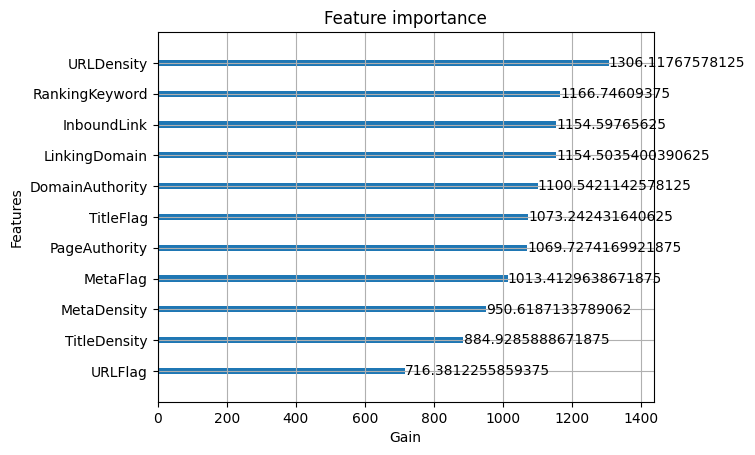

In [11]:
# Show the feature importance plot. Use plot_importance(your_model, importance_type = 'gain')
# If you don't see your plot, please run this cell again.
ax = plot_importance(reg, importance_type= 'gain')
ax.set_xlabel('Gain')
plt.show()

**Please interpret the importance value of the most important variable.** (5 points)

*ANSWER: HERE* <br>
The most important variable is TitleFlag with an average gain of 1306.1177. Since it has the highest average gain, it contributes more to the accuracy of the model. When TitleFlag is being used in a split, on average, it reduces the prediction error the most.

In [12]:
# Make prediction: y_pred should be the output of your prediction, it cotains value
# from 3 to 100 (may not be integers)
xgb_pred = reg.predict(X_test)

# printing range of predictions
print(xgb_pred.min())
print(xgb_pred.max())

12.040276
90.19816


In [13]:
## Print RMSE, y_test is a numpy array from test_label, y_pred is a numpy array from your model prediction

print(np.sqrt(mean_squared_error(y_test, xgb_pred)))

27.16181110559438


**Try different combinations of the hyper-parameters to get a lower RMSE.** (5 points)

Please note that you can use any hyper-parameter tuning techniques in the lecture. The points are not awarded based on the exact number of RMSE. As long as it is lower than the original values and you can justify the technique you use, you will be awarded the points.

## Tuning method selected: Grid Search
Justification:
- In a finite sample space, grid search is very effective as it will exhaustively iterate over all possible combinations and can find the best combination within the specified parameter grid.
- It is very simple to implement, since I can just specify a grid of fixed values. Grid search ensures that the optimal points within that grid will be found.

In [14]:
# your code here...

# Using Grid search to do hyper parameter tuning
from sklearn.model_selection import GridSearchCV

reg = xgb.XGBRegressor(max_depth = 6, 
                       eta = 0.1, 
                       gamma = 0.1,
                       subsample = 0.8,
                       colsample_bytree = 0.8,
                       alpha = 0.5,
                       objective = "reg:squarederror",
                       eval_metric = "rmse",
                       seed = 1)

# Define the parameter grid
param_grid = {
    'max_depth': [5, 6],  
    'eta' : [0.1, 0.2],
    'gamma': [0.1, 0.2],
    'subsample': [0.5, 0.8],  
    'colsample_bytree': [0.5, 0.8]
}

# Set up the grid search
grid_search = GridSearchCV(reg, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END colsample_bytree=0.5, eta=0.1, gamma=0.1, max_depth=5, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.5, eta=0.1, gamma=0.1, max_depth=5, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.5, eta=0.1, gamma=0.1, max_depth=5, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.5, eta=0.1, gamma=0.1, max_depth=5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.5, eta=0.1, gamma=0.1, max_depth=5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.5, eta=0.1, gamma=0.1, max_depth=5, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.5, eta=0.1, gamma=0.1, max_depth=6, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.5, eta=0.1, gamma=0.1, max_depth=6, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.5, eta=0.1, gamma=0.1, max_depth=6, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.5, eta=0.1, gamma=0.1, max_de

In [15]:
# redoing with new hyperparams

# reg_redone = xgb.XGBRegressor(max_depth = 5, 
#                        eta = 0.1, 
#                        gamma = 0.1,
#                        subsample = 0.8,
#                        colsample_bytree = 0.5,
#                        alpha = 0.5,
#                        objective = "reg:squarederror",
#                        eval_metric = "rmse",
#                        seed = 1)

reg_redone = xgb.XGBRegressor(max_depth = 5, 
                       eta = 0.1, 
                       gamma = 0.1,
                       subsample = 0.8,
                       colsample_bytree = 0.5,
                       alpha = 0.5,
                       objective = "reg:squarederror",
                       eval_metric = "rmse")
reg_redone.fit(X_train, y_train)
xgb_pred_redone = reg_redone.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, xgb_pred_redone)))

# RMSE is lower yay!

26.453451556674892


### Q2. Redo Q1 by using `rank:pairwise` for `objective` and `rmse` for `eval_metric`. (15 points)
Observe that we did not utilize the query information yet. However, in the dataset, we know that each query corresponds to 98 data points. Now we will leverage this information by setting group information for both training and testing data. (5 points)



In [4]:
# Model and Parameter Setting 
# Use xgb.XGBRanker
# Use parameters below first and you can adjust it later.
reg = xgb.XGBRanker(max_depth = 6, 
                           eta = 0.1, 
                           gamma = 0.1,
                           subsample = 0.8,
                           colsample_bytree = 0.8,
                           alpha = 0.5,
                           objective = "rank:pairwise",
                           eval_metric = "rmse")

In [5]:
# Data Input
feature_col =["TitleFlag", "TitleDensity", "URLFlag", "URLDensity", "MetaFlag", "MetaDensity", "PageAuthority", "DomainAuthority", "LinkingDomain", "InboundLink" , "RankingKeyword" ]
train_data = pd.read_csv("Train_dta.csv") 
test_data = pd.read_csv("Test_dta.csv") 

train_feature = pd.read_csv("Train_dta.csv",usecols=feature_col)
train_label = pd.read_csv("Train_dta.csv",usecols=["ReverseRank"]) 

test_feature = pd.read_csv("Test_dta.csv",usecols=feature_col)
test_label = pd.read_csv("Test_dta.csv",usecols=["ReverseRank"]) 

X_train = train_feature # trainig feature, as a dataframe in pandas
X_test = test_feature # test feature, as a df 

y_train = train_label.values # training label, as a numpy array
y_test = test_label.values # test label, as a np array

In [6]:
# Fit the model by your_model.fit(X_train, y_train, group = np.full(14,98))
reg.fit(X_train, y_train, group = np.full(14,98))

XGBRanker(alpha=0.5, base_score=None, booster=None, callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0.8,
          device=None, early_stopping_rounds=None, enable_categorical=False,
          eta=0.1, eval_metric='rmse', feature_types=None, gamma=0.1,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=None, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=None,
          n_jobs=None, ...)

C:\Users\zandr\AppData\Local\Temp\ipykernel_14880\3572660928.py:4: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


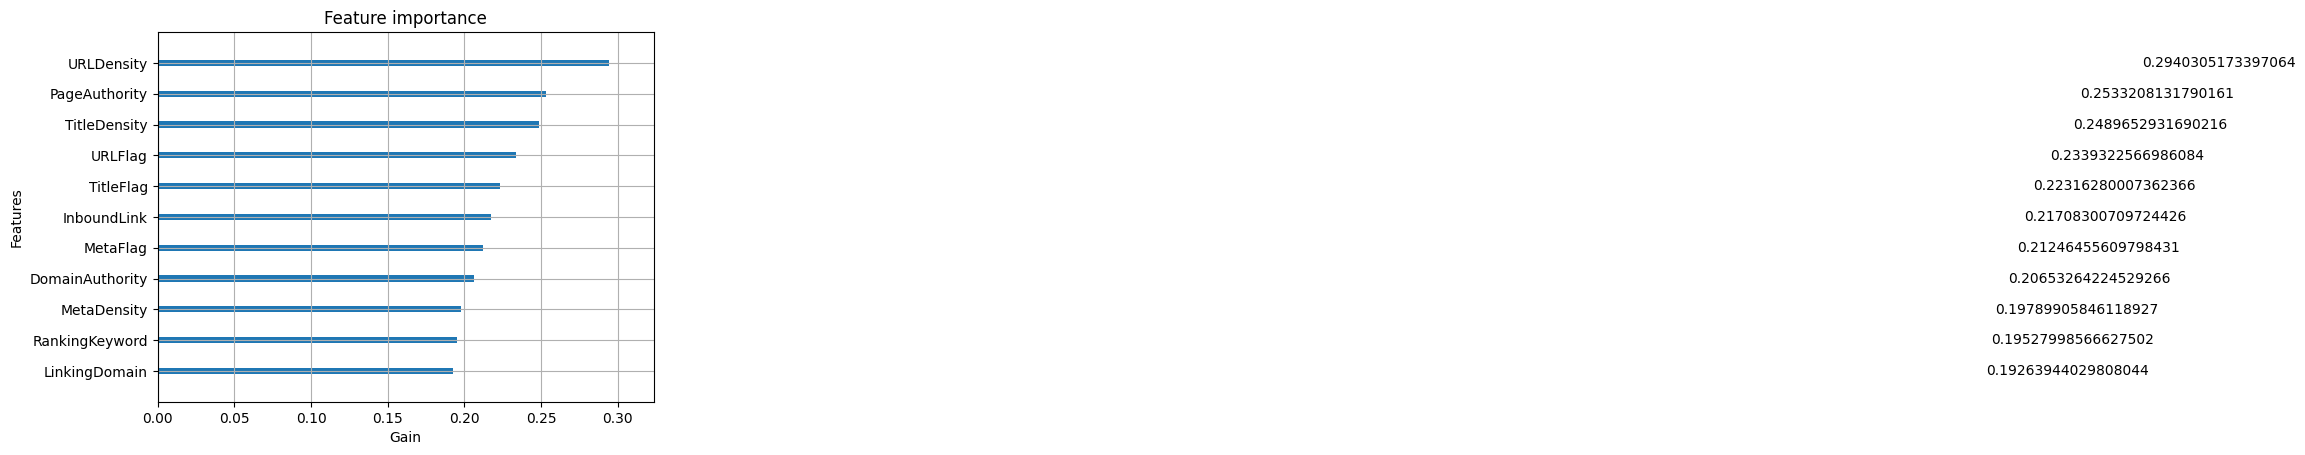

In [7]:
# Show the feature importance plot. Use plot_importance(your_model, importance_type = 'gain')
ax = plot_importance(reg, importance_type= 'gain')
ax.set_xlabel('Gain')
plt.tight_layout()
plt.show()

**Please interpret the importance value of the most important variable.** (5 points)

*ANSWER: HERE* <br>
The most important variable is URLDensity with an average gain of 0.29403. Since it has the highest average gain, it contributes more to the accuracy of the model. When URLDensity is being used in a split, on average, it reduces the prediction error the most.

Note that here `y_pred` is *not* a direct rank on itself. We need to figure out how to get the rank from `y_pred`. Test data can be divided into 6 groups, we need to perform the following steps for each group.
1. For each group, get `y_pred` from your model. 
2. The values in `y_pred` indicate a relative score for the rank. The higher the score, the better the page rank. For all 98 pages in one group, the page with the highest score should rank as 100, and the page with the lowest score should rank as 3. 
3. Repeat this for all groups. You are required to implement this by some simple codes. **y_pred_rank** is the predicted ranks you transformed from **y_pred**.



In [8]:
# Make prediction: y_pred is the predicted output from your model, y_pred_rank is the actual rank you get
# This is essentially k fold cross validation, where k = 6
X_test_split_6 = np.array_split(X_test, 6)

y_pred_rank = []
for i in X_test_split_6:
    y_pred = reg.predict(i)
    mapped_rank = np.argsort(y_pred)[::-1] + 3
    y_pred_rank.append(mapped_rank)

c:\Users\zandr\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [9]:
# Print RMSE, y_test is a numpy array from test_label, y_pred_rank is a numpy array from your model prediction
from itertools import chain

print(np.sqrt(mean_squared_error(list(chain(*y_pred_rank)), y_test)))

45.913072257055866


**Try different combinations of the hyper-parameters to get a lower RMSE.** (5 points)

Please note that you can use any hyper-parameter tuning techniques in the lecture. The points are not awarded based on the exact number of RMSE. As long as it is lower than the original values and you can justify the technique you use, you will be awarded the points.

### Tuning method selected: Bayesian Optimisation
Justification:
- It can utilize the historical values of the hyper-parameters previously sampled. The historical values can be incorporated into the sample range. For XGBRanker, this can help direct the optimization process when some domain knowledge is available about the problem.
- It is efficient -- needs to sample fewer points to learn the minimum point of $f$. This is particularly useful for XGBRanker, where each evaluation might require training a complex model on a large dataset.

In [15]:
# WITH SPLITTING
# Use Bayesian as the hyper parameter tuning method

import optuna

# Define the objective function
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_loguniform('eta', 0.08, 0.3),
        'gamma': trial.suggest_uniform('gamma', 0.08, 0.3),
        'subsample': trial.suggest_uniform('subsample', 0.2, 0.8),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.2, 0.8),
        'alpha': trial.suggest_uniform('alpha', 0, 1)
    }
    reg = xgb.XGBRanker(**params, objective='rank:pairwise', eval_metric='rmse')
        
    reg.fit(X_train, y_train, group=np.full(14,98))

    X_test_split_6 = np.array_split(X_test, 6)

    y_pred_rank = []
    for i in X_test_split_6:
        y_pred = reg.predict(i)
        mapped_rank = np.argsort(y_pred)[::-1] + 3
        y_pred_rank.append(mapped_rank)

    rmse = np.sqrt(mean_squared_error(list(chain(*y_pred_rank)), y_test))
    return rmse

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=130)

# Results
warnings.simplefilter('ignore', FutureWarning)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)


[I 2023-11-03 13:01:38,711] A new study created in memory with name: no-name-e600b604-6197-4ee1-86cd-be76df290c90


[I 2023-11-03 13:01:38,834] Trial 0 finished with value: 46.919528736665164 and parameters: {'max_depth': 6, 'eta': 0.08390521915537479, 'gamma': 0.1319680554026479, 'subsample': 0.21860113110512625, 'colsample_bytree': 0.5779719207536327, 'alpha': 0.7918546955737135}. Best is trial 0 with value: 46.919528736665164.
[I 2023-11-03 13:01:38,965] Trial 1 finished with value: 46.87176746223694 and parameters: {'max_depth': 5, 'eta': 0.2590522748568531, 'gamma': 0.08735884306653681, 'subsample': 0.29280444100845227, 'colsample_bytree': 0.48223089567564126, 'alpha': 0.6590819806287571}. Best is trial 1 with value: 46.87176746223694.
[I 2023-11-03 13:01:39,041] Trial 2 finished with value: 46.480337441841826 and parameters: {'max_depth': 8, 'eta': 0.21351919664634902, 'gamma': 0.23978825250774494, 'subsample': 0.3302838061433699, 'colsample_bytree': 0.5799892228524872, 'alpha': 0.8912151671306798}. Best is trial 2 with value: 46.480337441841826.
[I 2023-11-03 13:01:39,119] Trial 3 finished wi

Number of finished trials: 130
Best trial: {'max_depth': 8, 'eta': 0.24680806399847383, 'gamma': 0.11062562728782996, 'subsample': 0.7652261908799987, 'colsample_bytree': 0.3934269947177924, 'alpha': 0.06332250580516574}


In [16]:
# WITH SPLITTING
reg = xgb.XGBRanker(max_depth = 8, 
                    eta = 0.24680806399847383,
                    gamma = 0.11062562728782996,
                    subsample = 0.7652261908799987,
                    colsample_bytree = 0.3934269947177924,
                    alpha = 0.06332250580516574,
                    objective = "rank:pairwise",
                    eval_metric = "rmse")

reg.fit(X_train, y_train, group = np.full(14,98))

X_test_split_6 = np.array_split(X_test, 6)

y_pred_rank = []
for i in X_test_split_6:
    y_pred = reg.predict(i)
    mapped_rank = np.argsort(y_pred)[::-1] + 3
    y_pred_rank.append(mapped_rank)

print(np.sqrt(mean_squared_error(list(chain(*y_pred_rank)), y_test)))

# yay, rmse is lower! yippee

44.83492018535564


### Q3. Use `rank:ndcg` for `objective` and `rmse` for `eval_metric`. Redo Question 6. (10 points)

In [18]:
# Model and Parameter Setting 
# Use xgb.XGBRanker
# Use parameters below first and you can adjust it later.
reg = xgb.XGBRanker(max_depth = 6, 
                           eta = 0.1, 
                           gamma = 0.1,
                           subsample = 0.8,
                           colsample_bytree = 0.8,
                           alpha = 0.5,
                           objective = "rank:ndcg",
                           eval_metric = "rmse")

In [19]:
# Data Input
feature_col =["TitleFlag", "TitleDensity", "URLFlag", "URLDensity", "MetaFlag", "MetaDensity", "PageAuthority", "DomainAuthority", "LinkingDomain", "InboundLink" , "RankingKeyword" ]
train_data = pd.read_csv("Train_dta.csv") 
test_data = pd.read_csv("Test_dta.csv") 

train_feature = pd.read_csv("Train_dta.csv",usecols=feature_col)
train_label = pd.read_csv("Train_dta.csv",usecols=["ReverseRank"]) 

test_feature = pd.read_csv("Test_dta.csv",usecols=feature_col)
test_label = pd.read_csv("Test_dta.csv",usecols=["ReverseRank"]) 

X_train = train_feature # trainig feature, as a dataframe in pandas
X_test = test_feature # test feature, as a df 

y_train = train_label.values # training label, as a numpy array
y_test = test_label.values # test label, as a np array

In [20]:
def scale_relevance_scores(y_train, new_min=0, new_max=31):
    old_min = np.min(y_train)
    old_max = np.max(y_train)
    
    scaled_scores = (y_train - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
    return np.round(scaled_scores).astype(int)

y_train_scaled = scale_relevance_scores(y_train)


In [21]:
# Fit the model by your_model.fit(X_train, y_train, group = np.full(14,98))
reg.fit(X_train, y_train_scaled, group = np.full(14,98))

XGBRanker(alpha=0.5, base_score=None, booster=None, callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0.8,
          device=None, early_stopping_rounds=None, enable_categorical=False,
          eta=0.1, eval_metric='rmse', feature_types=None, gamma=0.1,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=None, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=None,
          n_jobs=None, ...)

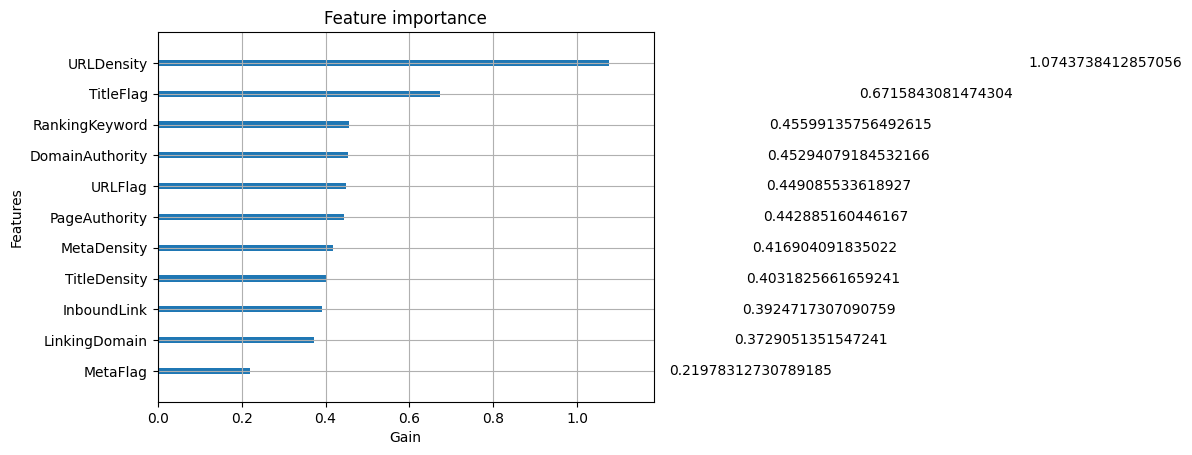

In [159]:
# Show the feature importance plot. Use plot_importance(your_model, importance_type = 'gain')
ax = plot_importance(reg, importance_type= 'gain')
ax.set_xlabel('Gain')
plt.show()

**Please interpret the importance value of the most important variable.** (5 points)

*ANSWER: HERE* <br>
The most important variable is URLDensity with an average gain of 1.07437. Since it has the highest average gain, it contributes more to the accuracy of the model. When URLDensity is being used in a split, on average, it reduces the prediction error the most.

In [22]:
# Make prediction: y_pred is the predicted output from your model, y_pred_rank is the actual rank you get
X_test_split_6 = np.array_split(X_test, 6)

y_pred_rank = []
for i in X_test_split_6:
    y_pred = reg.predict(i)
    mapped_rank = np.argsort(y_pred)[::-1] + 3
    y_pred_rank.append(mapped_rank)

In [23]:
# Print RMSE, y_test is a numpy array from test_label, y_pred_rank is a numpy array from your model prediction
print(np.sqrt(mean_squared_error(list(chain(*y_pred_rank)), y_test)))

45.78955856381876


**Try different combinations of the hyper-parameters to get a lower RMSE.** (5 points)

Please note that you can use any hyper-parameter tuning techniques in the lecture. The points are not awarded based on the exact number of RMSE. As long as it is lower than the original values and you can justify the technique you use, you will be awarded the points.

### Tuning method selected: Bayesian Optimisation
Justification:
- It can utilize the historical values of the hyper-parameters previously sampled. The historical values can be incorporated into the sample range. For XGBRanker, this can help direct the optimization process when some domain knowledge is available about the problem.
- It is efficient -- needs to sample fewer points to learn the minimum point of $f$. This is particularly useful for XGBRanker, where each evaluation might require training a complex model on a large dataset.

In [24]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score

# Define the objective function
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'eta': trial.suggest_loguniform('eta', 0.08, 0.12),
        'gamma': trial.suggest_uniform('gamma', 0.08, 0.12),
        'subsample': trial.suggest_uniform('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.2, 1.0),
        'alpha': trial.suggest_uniform('alpha', 0, 1)
    }
    reg = xgb.XGBRanker(
        **params, 
        objective='rank:ndcg',  
        eval_metric='rmse',  
        ndcg_exp_gain=False 
    )
    
    reg.fit(X_train, y_train_scaled, group = np.full(14,98))

    X_test_split_6 = np.array_split(X_test, 6)

    y_pred_rank = []
    for i in X_test_split_6:
        y_pred = reg.predict(i)
        mapped_rank = np.argsort(y_pred)[::-1] + 3
        y_pred_rank.append(mapped_rank)
    
    return np.sqrt(mean_squared_error(list(chain(*y_pred_rank)), y_test))

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Results
warnings.simplefilter('ignore', FutureWarning)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)


[I 2023-11-03 13:03:34,450] A new study created in memory with name: no-name-3d5c7ae2-952a-4ef5-b29e-14bca883ed47
[I 2023-11-03 13:03:34,555] Trial 0 finished with value: 46.56335746596675 and parameters: {'max_depth': 6, 'eta': 0.09284438650530796, 'gamma': 0.09660755940054537, 'subsample': 0.3799251879785379, 'colsample_bytree': 0.7524294242554104, 'alpha': 0.5585253798989376}. Best is trial 0 with value: 46.56335746596675.
[I 2023-11-03 13:03:34,654] Trial 1 finished with value: 46.57957130100098 and parameters: {'max_depth': 5, 'eta': 0.09518970155706598, 'gamma': 0.10853741190835015, 'subsample': 0.817969193410623, 'colsample_bytree': 0.3962068362372736, 'alpha': 0.5086215939387683}. Best is trial 0 with value: 46.56335746596675.
[I 2023-11-03 13:03:34,771] Trial 2 finished with value: 46.370036360874714 and parameters: {'max_depth': 5, 'eta': 0.11437778274978821, 'gamma': 0.09721200376172712, 'subsample': 0.49777462036045145, 'colsample_bytree': 0.6368283047220669, 'alpha': 0.230

Number of finished trials: 100
Best trial: {'max_depth': 6, 'eta': 0.08446883830623063, 'gamma': 0.11074897413208516, 'subsample': 0.919846389948706, 'colsample_bytree': 0.9844191636850745, 'alpha': 0.8233243745029407}


In [27]:
reg = xgb.XGBRanker(max_depth = 6, 
                    eta = 0.08446883830623063, 
                    gamma = 0.11074897413208516,
                    subsample = 0.919846389948706,
                    colsample_bytree = 0.9844191636850745,
                    alpha = 0.8233243745029407,
                    objective = "rank:ndcg",
                    eval_metric = "rmse",
                    ndcg_exp_gain=False)

reg.fit(X_train, y_train_scaled, group = np.full(14,98))

X_test_split_6 = np.array_split(X_test, 6)

y_pred_rank = []
for i in X_test_split_6:
    y_pred = reg.predict(i)
    mapped_rank = np.argsort(y_pred)[::-1] + 3
    y_pred_rank.append(mapped_rank)

print(np.sqrt(mean_squared_error(list(chain(*y_pred_rank)), y_test)))


# RMSE is lower too! YIBBEEE!!!

45.403557054456414


## Problem 3. Interpretation Short-Answers (10 points)

Please paste the RMSE values of all questions above in the table below. Please round your RMSE up to 4 decimals.

To access the table written in markdown below, double click the placeholder table, edit the corresponding value and run the cell. 


Before Tuning:

| Question | P1-Q1 | P1-Q2 | P1-Q3 | P1-Q4 | P2-Q5 | P2-Q6 | P2-Q7 |
| --- | --- | --- | --- | --- | --- | --- | --- |
| RMSE | 37.1507 | 37.6191 | 38.9111 | 26.5586 | 27.4849 | 45.9131 | 45.7896 |

After Tuning:

| Question | P2-Q5 | P2-Q6 | P2-Q7 |
| --- | --- | --- | --- | 
| RMSE | 26.3466 | 44.8349 | 45.4036 |

**Question: Please describe what you observe from the RMSE value for all methods of pointwise ranking. What is the best method? Why? (5 points)**

Answer: HERE <br>
Random Forest is the best method for pointwise ranking, with a RMSE of 26.5586.
It is an ensemble method which makes use of many ind.ependently grown trees. Each tree is trained using a subset of original training dataset.
Each tree uses a subset of features. Hence, they are all representatives of the underlying data-generating process; and averaging across them can reduce bias from overfitting. Due to the averaging of predictions from numerous trees, Random Forests are less sensitive to noisy data.

**Question: Please compare the results from pointwise ranking and pairwise ranking and describe your observatins.(5 points)**

Answer: HERE <br>
On average, my results from pointwise ranking has lower RMSE than pairwise ranking. Since I am using RMSE as the `eval_metric`, pointwise ranking performs better as it directly optimises for accuracy of predictions, while pairwise ranking optimises for the correct ordering of items.

# Appendix

1. ID: identification number (i.e., row number in the dataset)

2. Position: the actual google ranking of the webpage to the query

3. ReverseRank: equals $101$ minus Position. It is equivalent to the position. Sometimes using ReverseRank as the dependent variable can have a better prediction.

4. Title: the title of the webpage

5. URL: the URL of the webpage

6. Meta: the meta description of the webpage

7.	TitleFlag: indicates that whether the whole keyword is included in the page title. TitleFlag equals 1 if yes, otherwise, 0.

8.	UrlFlag: indicates that whether the whole keyword is included in the page url. UrlFlag equals 1 if yes, otherwise, 0.

9.	MetaFlag: indicates that whether the whole keyword is included in the page meta description. MetaFlag equals 1 if yes, otherwise, 0.

10.	TitleDensity: is the percentage of times a keyword appears in the title of a web page compared to the total number of words in the title of a web page.

11.	UrlDensity: is the percentage of times a keyword appears in the URL of a web page compared to the total number of words in the URL of a web page.

12.	MetaDensity: is the percentage of times a keyword appears in the meta description of a web page compared to the total number of words in the meta description of a web page.

13.	PageAuthority: is a score developed by Moz that predicts how well a specific page will rank on search engine result pages (SERP). https://moz.com/learn/seo/page-authority

14.	DomainAuthority: is a search engine ranking score developed by Moz that predicts how well a website will rank on search engine result pages (SERPs). https://moz.com/learn/seo/domain-authority

15.	LinkingDomain: is the number of unique external domains linking to this page. Two or more links from the same websites are considered as one linking domain. Provided by Moz.

16.	InboundLink: is the number of unique external pages linking to this page. Two or more links from the same page on a website are considered as one inbound link. Provided by Moz.

17.	RankingKeyword: is the number of keywords for which this site ranks within the top 50 positions on Google US. Provided by Moz.